# Demo Large-scale Model Fitting

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from models.dmf import dmf
from models.hopf import hopf
from models.optimization.differential_evolution import Dev

from analysis.io import Data
from analysis.utils import linearize_map, normalize_sc, subdiag
import analysis.cifti as cifti

Load **average FC**, **average SC**, **median-symmetrized T1w/T2w** maps and **approximated posterior distribution** of the parameters as reported in Demirtas et al., 2019. The first 180 indices corresponds to right hemisphere. SC matrix is normalized using `normalize_sc` method and T1w/T2w map is linearized using `linearize_map` method.

In [4]:
data = Data()
file = data.load('data/demirtas_neuron_2019.hdf5')
fc_hcp = file['fc'][()][:180,:180]
sc_hcp = file['sc'][()][:180,:180]
t1wt2w_hcp = file['t1wt2w'][()]
theta = file['apprx_posterior_heterogeneous'][()]
file.close()

hmap_hcp = linearize_map(t1wt2w_hcp[:180])
sc_hcp = normalize_sc(sc_hcp)

Draw a sample from posterior distribution.

In [5]:
s = 0
dmf_sample = dmf.Model(sc_hcp, hmap=hmap_hcp)
dmf_sample.w_EI = theta[:2,s]
dmf_sample.w_EE = theta[2:4,s]
dmf_sample.G = theta[5,s]
dmf_sample.set_jacobian(compute_fic=True)
dmf_sample.moments_method(bold = True)
print('Model fit for sample ' + str(s) + ' is r = ' + str(stats.pearsonr(subdiag(dmf_sample.corr_bold), subdiag(fc_hcp))[0]))
print('w_EI min. = ' + str(theta[0,s]) + ', w_EI scale. = ' + str(theta[1,s]))
print('w_EE min. = ' + str(theta[2,s]) + ', w_EE scale. = ' + str(theta[3,s]))
print('g         = ' + str(theta[5,s]))

Model fit for sample 0 is r = 0.5690188941793339
w_EI min. = 1.0200650456177685, w_EI scale. = 0.18933598404840427
w_EE min. = 3.9119814855020127, w_EE scale. = 2.6352056961819015
g         = 0.10216088028916731


Model optimization using differential evolution. The classes are derived from `lib.models.optimization.differential_evolution` module, in which the differential evolution method of `scipy` was used. It brief, each class is initiated by the model, an objective (simply FC in this case) and parameter dictionary. Since the model classes are different for Hopf and DMF models, we need to inherit the `Dev` class and then override abstract function `cost_function`.

In [6]:
class Opt_Hopf(Dev):
    def cost_function(self):
        self.model.moments_method()
        if not self.model._unstable:
            fc_model = self.model.corr
            r = -np.corrcoef(subdiag(fc_model), self.objective)[0,1]
        else:
            r = self.model.evals.max().real
        return r 
    
class Opt_Dmf(Dev):
    def cost_function(self):
        self.model.set_jacobian(compute_fic=True)
        if not self.model._unstable:
            self.model.moments_method(bold = True)
            fc_model = self.model.corr_bold
            r = -np.corrcoef(subdiag(fc_model), self.objective)[0,1]
        else:
            r = self.model.evals.max().real
        return r

**Optimization of Hopf model:**

In [7]:
hopf_model_base = hopf.HopfModel(sc_hcp, np.ones(180) * 0.05, hmap=-hmap_hcp, a = [-1.0, 0.5])
hopf_parameter_dictionary = {'a': ((-5.0, 0.0), (0.0, 5.0)), 
                             'g': ((0.001, 5.),)}
opt_hopf = Opt_Hopf(hopf_model_base, subdiag(fc_hcp), hopf_parameter_dictionary)
opt_hopf.run()

differential_evolution step 1: f(x)= -0.553588
differential_evolution step 2: f(x)= -0.553588
differential_evolution step 3: f(x)= -0.553588
differential_evolution step 4: f(x)= -0.553588
differential_evolution step 5: f(x)= -0.559723
differential_evolution step 6: f(x)= -0.588733
differential_evolution step 7: f(x)= -0.605658
differential_evolution step 8: f(x)= -0.605658
differential_evolution step 9: f(x)= -0.605658
differential_evolution step 10: f(x)= -0.605658
differential_evolution step 11: f(x)= -0.605658
differential_evolution step 12: f(x)= -0.605658
differential_evolution step 13: f(x)= -0.606421
differential_evolution step 14: f(x)= -0.606421
differential_evolution step 15: f(x)= -0.606421
differential_evolution step 16: f(x)= -0.606421
differential_evolution step 17: f(x)= -0.606632
differential_evolution step 18: f(x)= -0.607
differential_evolution step 19: f(x)= -0.607
differential_evolution step 20: f(x)= -0.607164
differential_evolution step 21: f(x)= -0.607171
differe

Show optimal parameters and generate sample:

In [8]:
print("Optimal parameters for Hopf: " + str(opt_hopf.opt_params))
opt_hopf.sample(opt_hopf.opt_params)
opt_hopf.model.moments_method()
hm = opt_hopf.model

Optimal parameters for Hopf: [-2.49732145  3.47418259  4.79555621]


Extract network indices

In [9]:
# Load network indices for Glasser 360 (as in Neuron 2019 paper)
network_names, network_indices = cifti.get_networks()
network_names = ['AUD', 'VIS', 'SOM', 'DAN', 'FPN', 'VAN', 'DMN', 'CON', 'Oth']

network_indices2 = {}
for key in network_names:
    network_indices2[key] = network_indices[key][0][network_indices[key][0] < 180]

network_order = network_indices['AUD'][0]
for i in range(1, len(network_names)):
    network_order = np.hstack((network_order, network_indices[network_names[i]][0]))
network_order = network_order[network_order < 180]

Plot model and empirical FC matrices:

Text(0.5, 1.0, 'FC empirical')

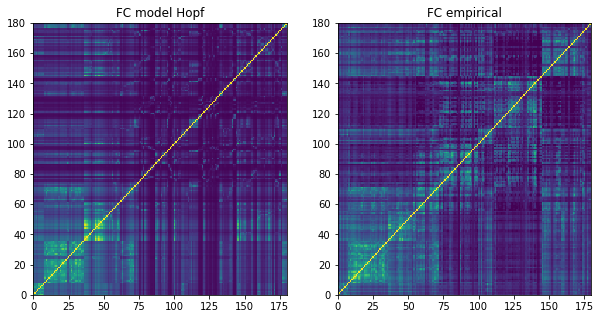

In [10]:
f, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].pcolormesh(hm.corr[network_order,:][:,network_order], vmin = 0.0, vmax = 1.0)
ax[0].set_title('FC model Hopf')
ax[1].pcolormesh(fc_hcp[network_order,:][:,network_order], vmin = 0.0, vmax = 1.0)
ax[1].set_title('FC empirical')

An example plot showing model fit for FC and GBC

Text(0.5, 1.0, 'GBC fit')

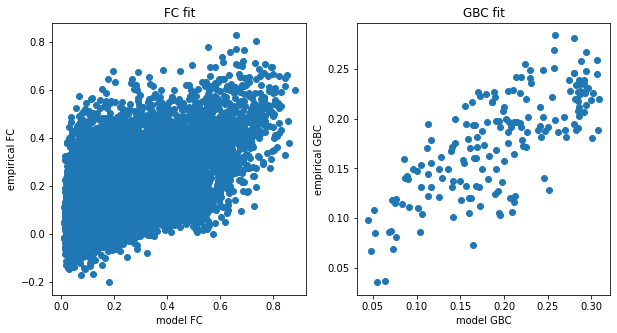

In [7]:
f, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(subdiag(dmf_sample.corr_bold), subdiag(fc_hcp))
ax[0].set_ylabel('empirical FC')
ax[0].set_xlabel('model FC')
ax[0].set_title('FC fit')
ax[1].scatter(dmf_sample.corr_bold.mean(1), fc_hcp.mean(1))
ax[1].set_ylabel('empirical GBC')
ax[1].set_xlabel('model GBC')
ax[1].set_title('GBC fit')

Simulating the model for 150 seconds:

In [67]:
from analysis.signal import bandpass
from analysis.utils import phase_lock
dmf_sample.sigma = 1e-4
dmf_sample.integrate(t = 150, n_save = 10)

Beginning simulation.
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
Simulation complete.


After removing the first 5 seconds and downsampling at 0.72 Hz (as in HCP data) the simulated BOLD signals looks like:

Text(0.5, 1.0, 'simulated TS (cropped and downsampled)')

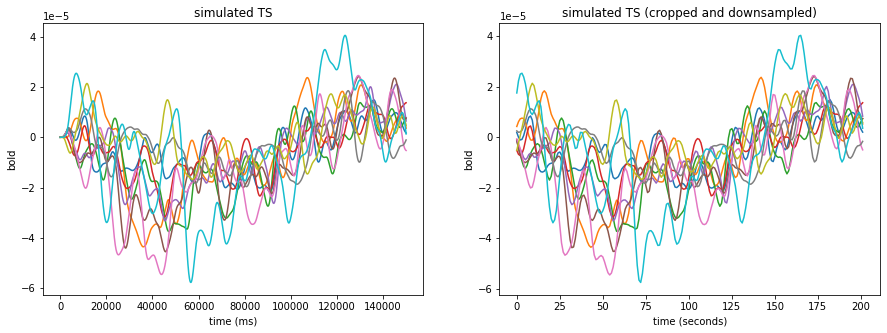

In [73]:
crop_init = 5 * 1000 # ms

f, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(dmf_sample.sim.y[:10].T)
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('bold')
ax[0].set_title('simulated TS')
ax[1].plot(dmf_sample.sim.y[:10].T[crop_init:][::720])
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('bold')
ax[1].set_title('simulated TS (cropped and downsampled)')

We can compute phase coherence connectivity matrices in time as follows:

In [69]:
ts = dmf_sample.sim.y[:,crop_init:][:,::720]
print(ts.shape)
ts_filtered = bandpass(ts, fs = 0.72, flp = 0.04, fhp = 0.07, order = 2)
plvs = phase_lock(ts_filtered, method = 'cosine')

(180, 202)


Plotting FCD and its distribution:

Text(0.5, 1.0, 'FCD distribution')

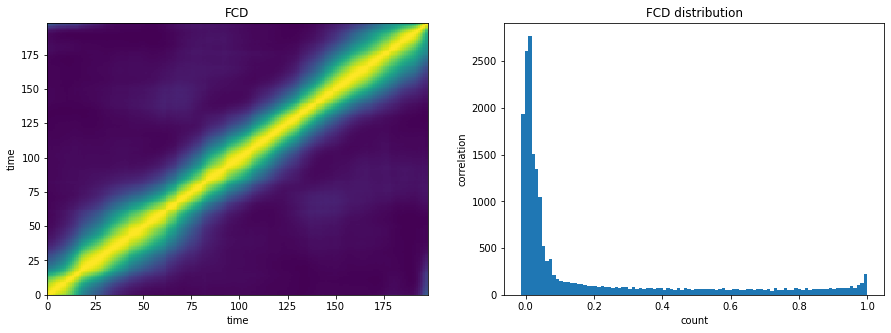

In [74]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].pcolormesh(np.corrcoef(plvs[:,2:-2].T))
ax[0].set_ylabel('time')
ax[0].set_xlabel('time')
ax[0].set_title('FCD')
hst = ax[1].hist(subdiag(np.corrcoef(plvs[:,2:-2].T)), bins = 100)
ax[1].set_ylabel('correlation')
ax[1].set_xlabel('count')
ax[1].set_title('FCD distribution')